<a id='notebook-top'></a>
This notebook estimates the EIS stray light intensity in the upflow regions. The short range and long range components of the EIS stray light are 
calculated from the equations given by [Young & Viall (2022)](https://ui.adsabs.harvard.edu/abs/2022ApJ...938...27Y). The intensity distributions 
in ambient coronal holes are also compared with the intensity distributions in upflow regions. Link to [Figure C.1](#figure-c-1).

Note: The internal hyperlink only works on [GitHub Pages](https://yjzhu-solar.github.io/EIS_DKIST_SolO/app_eis_stray_light.html) or [nbviewer](https://nbviewer.org/github/yjzhu-solar/EIS_DKIST_SolO/blob/master/ipynb/ms_eis_eui_upflow/app_eis_stray_light.ipynb). Do not click when viewing the notebook on GitHub.

In [27]:
import eispac
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rcParams, rc_context
import matplotlib.patheffects as path_effects
import sunpy
import sunpy.map
import pandas as pd
import os
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.constants as const
from regions import (PolygonSkyRegion,EllipsePixelRegion, PixCoord)
import shapely
from scipy.io import readsav
import scipy.interpolate
from scipy.stats import gaussian_kde
from astropy.visualization import (ImageNormalize, SqrtStretch, 
                                   AsinhStretch, LogStretch)
from eis_straylight import calc_short_range_stray_light, calc_long_range_stray_light_aia_eis, coalign_eis_aia
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cmcrameri.cm as cmcm

In [2]:
ms_style_dict = {'text.usetex': True, 'font.family': 'serif', 'axes.linewidth': 1.2,
                 'xtick.major.width': 1.2, 'xtick.major.size': 4,
                 'ytick.major.width': 1.2, 'ytick.major.size': 4,
                 'xtick.minor.width': 1.2, 'xtick.minor.size': 2,
                 'ytick.minor.width': 1.2, 'ytick.minor.size': 2,
                 'xtick.direction': 'in', 'ytick.direction': 'in',
                 'text.latex.preamble': r'\usepackage[T1]{fontenc}'
                 r'\usepackage{amsmath}' r'\usepackage{siunitx}'
                 r'\sisetup{detect-all=True}'}

In [3]:
aia_131_map_1025 = sunpy.map.Map('../../src/AIA/20221025/131/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.131.image.fits')
aia_171_map_1025 = sunpy.map.Map('../../src/AIA/20221025/171/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.171.image.fits')
aia_193_map_1025 = sunpy.map.Map('../../src/AIA/20221025/193/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.193.image.fits')
aia_211_map_1025 = sunpy.map.Map('../../src/AIA/20221025/211/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.211.image.fits')
aia_335_map_1025 = sunpy.map.Map('../../src/AIA/20221025/335/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.335.image.fits')
aia_94_map_1025 = sunpy.map.Map('../../src/AIA/20221025/94/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.94.image.fits')

In [4]:
eis_file_prefix_1025 = '../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.'

In [5]:
eis_FeXII_195_fitres_1025 = eispac.read_fit(eis_file_prefix_1025 + 'fe_12_195_119.1c-0.fit.h5')
eis_FeXII_195_intmap_1025 = eis_FeXII_195_fitres_1025.get_map(component=0, measurement='intensity')
eis_FeXII_195_velmap_1025 = eis_FeXII_195_fitres_1025.get_map(component=0, measurement='velocity')
eis_FeXII_195_widmap_1025 = eis_FeXII_195_fitres_1025.get_map(component=0, measurement='width')

Txshift_aia_eis_rough_1025, Tyshift_aia_eis_rough_1025 = coalign_eis_aia(eis_FeXII_195_intmap_1025, aia_193_map_1025)
eis_FeXII_195_intmap_1025 = eis_FeXII_195_intmap_1025.shift_reference_coord(Txshift_aia_eis_rough_1025, Tyshift_aia_eis_rough_1025)
eis_FeXII_195_velmap_1025 = eis_FeXII_195_velmap_1025.shift_reference_coord(Txshift_aia_eis_rough_1025, Tyshift_aia_eis_rough_1025)
eis_FeXII_195_widmap_1025 = eis_FeXII_195_widmap_1025.shift_reference_coord(Txshift_aia_eis_rough_1025, Tyshift_aia_eis_rough_1025)

c = const.c.cgs.value
amu = const.u.cgs.value
k_B = const.k_B.cgs.value

FeXII_195_true_width_fwhm_1025 = np.sqrt((eis_FeXII_195_widmap_1025.data * np.sqrt(8*np.log(2)))**2 - \
                                    eis_FeXII_195_fitres_1025.meta["slit_width"][:,np.newaxis]**2)
FeXII_195_v1oe_1025 = FeXII_195_true_width_fwhm_1025/np.sqrt(4*np.log(2))*c/195.119
FeXII_195_vth2_1025 = 2*k_B*10**6.25/amu/55.85
FeXII_195_vnth_1025 = np.sqrt(FeXII_195_v1oe_1025**2 - FeXII_195_vth2_1025)
eis_FeXII_195_vnthmap_1025 = sunpy.map.Map(FeXII_195_vnth_1025/1e5, eis_FeXII_195_widmap_1025.meta)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_134815/1699743693.py:15: RuntimeWarning: invalid value encountered in sqrt
  FeXII_195_true_width_fwhm_1025 = np.sqrt((eis_FeXII_195_widmap_1025.data * np.sqrt(8*np.log(2)))**2 - \
/tmp/ipykernel_134815/1699743693.py:19: RuntimeWarning: invalid value encountered in sqrt
  FeXII_195_vnth_1025 = np.sqrt(FeXII_195_v1oe_1025**2 - FeXII_195_vth2_1025)


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


(150.0, 350.0)

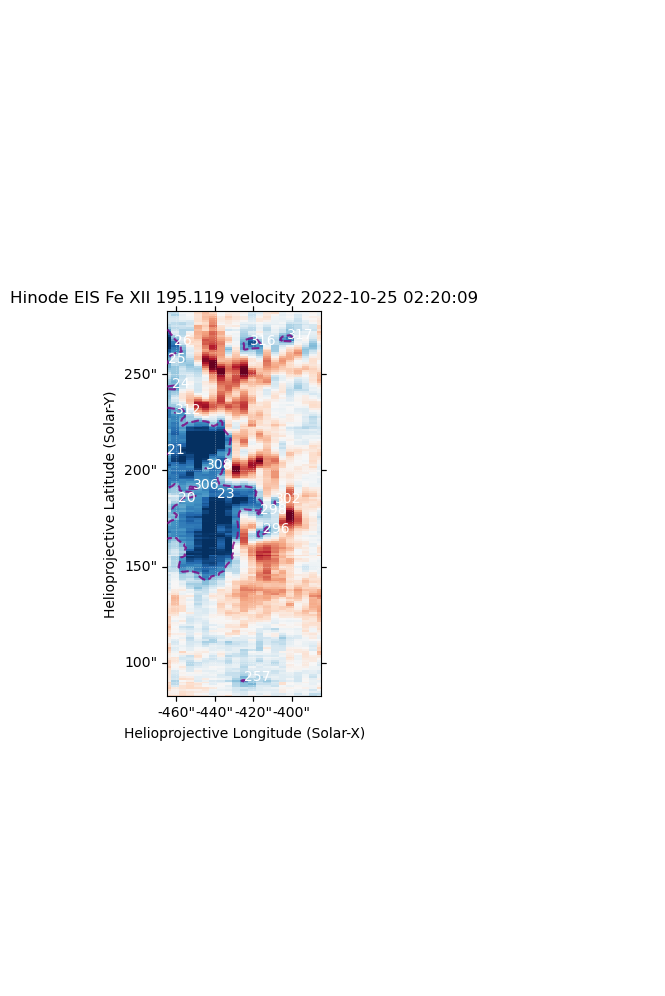

In [6]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection=eis_FeXII_195_velmap_1025)
eis_FeXII_195_velmap_1025.plot(axes=ax)

cs_1025 = eis_FeXII_195_velmap_1025.draw_contours(levels=[-5,]*eis_FeXII_195_velmap_1025.unit,colors=["purple"],axes=ax,alpha=0.8)

for ii, seg in enumerate(cs_1025.allsegs[0]):
    ax.text(np.nanmean(seg, axis=0)[0], np.nanmean(seg, axis=0)[1], f'{ii}', color='white', fontsize=10)

ax.set_xlim(0,20)
ax.set_ylim(150,350)



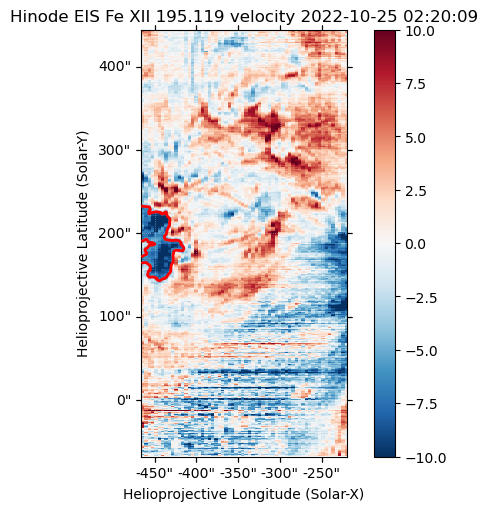

In [7]:
cs_selected_index_1025 = [20,23]
    
fig = plt.figure(figsize=(7, 5),layout='constrained')
ax = fig.add_subplot(111, projection=eis_FeXII_195_velmap_1025)
eis_FeXII_195_velmap_1025.plot(axes=ax)
plt.colorbar()

for ii in cs_selected_index_1025:
    ax.plot(*cs_1025.allsegs[0][ii].T, color='red', lw=2)

In [8]:
cs_skycoords_1025 = [eis_FeXII_195_velmap_1025.pixel_to_world(np.concatenate((cs_1025.allsegs[0][cs_selected_index_1025[0]][:,0],
                                                                    cs_1025.allsegs[0][cs_selected_index_1025[1]][:,0]))*u.pix,
                                                    np.concatenate((cs_1025.allsegs[0][cs_selected_index_1025[0]][:,1],
                                                                    cs_1025.allsegs[0][cs_selected_index_1025[1]][:,1]))*u.pix) \
                ]
cs_regions_1025 = [PolygonSkyRegion(vertices=cs_skycoord) for cs_skycoord in cs_skycoords_1025]

In [9]:
coronal_hole_ref_region_center_1025=SkyCoord(-330*u.arcsec, 30*u.arcsec, frame=eis_FeXII_195_intmap_1025.coordinate_frame)
eis_FeXII_195_intmap_coronal_hole_pixel_region_1025 = EllipsePixelRegion(center=PixCoord.from_sky(coronal_hole_ref_region_center_1025,
                                                                                                   eis_FeXII_195_intmap_1025.wcs),
                                            width=(60*u.arcsec/eis_FeXII_195_intmap_1025.scale.axis1).to_value(u.pix), 
                                            height=(60*u.arcsec/eis_FeXII_195_intmap_1025.scale.axis2).to_value(u.pix))
coronal_hole_ref_region_params_1025 = {'center':coronal_hole_ref_region_center_1025, 'width':60*u.arcsec, 'height':60*u.arcsec}

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [10]:
aia_131_map_1021 = sunpy.map.Map('../../src/AIA/20221021/131/lvl15/aia.lev1_euv_12s.2022-10-21T014039Z.131.image.fits')
aia_171_map_1021 = sunpy.map.Map('../../src/AIA/20221021/171/lvl15/aia.lev1_euv_12s.2022-10-21T014039Z.171.image.fits')
aia_193_map_1021 = sunpy.map.Map('../../src/AIA/20221021/193/lvl15/aia.lev1_euv_12s.2022-10-21T014039Z.193.image.fits')
aia_211_map_1021 = sunpy.map.Map('../../src/AIA/20221021/211/lvl15/aia.lev1_euv_12s.2022-10-21T014039Z.211.image.fits')
aia_335_map_1021 = sunpy.map.Map('../../src/AIA/20221021/335/lvl15/aia.lev1_euv_12s.2022-10-21T014039Z.335.image.fits')
aia_94_map_1021 = sunpy.map.Map('../../src/AIA/20221021/94/lvl15/aia.lev1_euv_12s.2022-10-21T014039Z.94.image.fits')

In [11]:
eis_file_prefix_1021 = '../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.'

In [12]:
eis_FeXII_195_fitres_1021 = eispac.read_fit(eis_file_prefix_1021 + 'fe_12_195_119.1c-0.fit.h5')
eis_FeXII_195_intmap_1021 = eis_FeXII_195_fitres_1021.get_map(component=0, measurement='intensity')
eis_FeXII_195_velmap_1021 = eis_FeXII_195_fitres_1021.get_map(component=0, measurement='velocity')
eis_FeXII_195_widmap_1021 = eis_FeXII_195_fitres_1021.get_map(component=0, measurement='width')

Txshift_aia_eis_rough_1021, Tyshift_aia_eis_rough_1021 = coalign_eis_aia(eis_FeXII_195_intmap_1021, aia_193_map_1021)
eis_FeXII_195_intmap_1021 = eis_FeXII_195_intmap_1021.shift_reference_coord(Txshift_aia_eis_rough_1021, Tyshift_aia_eis_rough_1021)
eis_FeXII_195_velmap_1021 = eis_FeXII_195_velmap_1021.shift_reference_coord(Txshift_aia_eis_rough_1021, Tyshift_aia_eis_rough_1021)
eis_FeXII_195_widmap_1021 = eis_FeXII_195_widmap_1021.shift_reference_coord(Txshift_aia_eis_rough_1021, Tyshift_aia_eis_rough_1021)

c = const.c.cgs.value
amu = const.u.cgs.value
k_B = const.k_B.cgs.value

FeXII_195_true_width_fwhm_1021 = np.sqrt((eis_FeXII_195_widmap_1021.data * np.sqrt(8*np.log(2)))**2 - \
                                    eis_FeXII_195_fitres_1021.meta["slit_width"][:,np.newaxis]**2)
FeXII_195_v1oe_1021 = FeXII_195_true_width_fwhm_1021/np.sqrt(4*np.log(2))*c/195.119
FeXII_195_vth2_1021 = 2*k_B*10**6.25/amu/55.85
FeXII_195_vnth_1021 = np.sqrt(FeXII_195_v1oe_1021**2 - FeXII_195_vth2_1021)
eis_FeXII_195_vnthmap_1021 = sunpy.map.Map(FeXII_195_vnth_1021/1e5, eis_FeXII_195_widmap_1021.meta)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_134815/2173341581.py:15: RuntimeWarning: invalid value encountered in sqrt
  FeXII_195_true_width_fwhm_1021 = np.sqrt((eis_FeXII_195_widmap_1021.data * np.sqrt(8*np.log(2)))**2 - \
/tmp/ipykernel_134815/2173341581.py:19: RuntimeWarning: invalid value encountered in sqrt
  FeXII_195_vnth_1021 = np.sqrt(FeXII_195_v1oe_1021**2 - FeXII_195_vth2_1021)


In [13]:
eis_FeXIV_270_intmap_1021 = eispac.read_fit(eis_file_prefix_1021 + 'fe_14_270_519.2c-1.fit.h5').get_map(component=1, measurement='intensity')
eis_FeXIV_270_intmap_1021 = eis_FeXIV_270_intmap_1021.shift_reference_coord(Txshift_aia_eis_rough_1021, Tyshift_aia_eis_rough_1021)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_14_270_519.2c-1.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


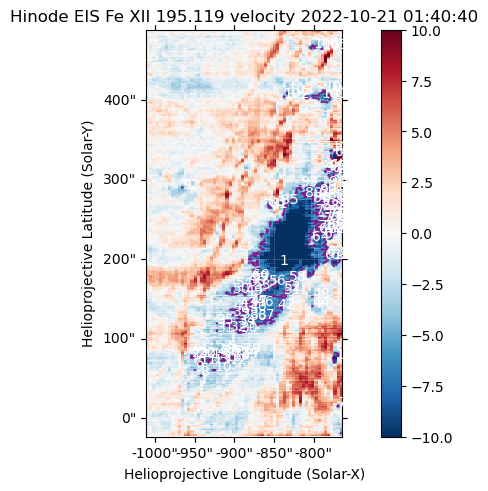

In [14]:
fig = plt.figure(layout='constrained')

ax = fig.add_subplot(111, projection=eis_FeXII_195_velmap_1021)
eis_FeXII_195_velmap_1021.plot(axes=ax)

cs_1021 = eis_FeXII_195_velmap_1021.draw_contours(levels=[-5,]*eis_FeXII_195_velmap_1021.unit,colors=["purple"],axes=ax,alpha=0.8)
plt.colorbar()

for ii, seg in enumerate(cs_1021.allsegs[0]):
    ax.text(np.nanmean(seg, axis=0)[0], np.nanmean(seg, axis=0)[1], f'{ii}', color='white', fontsize=10)

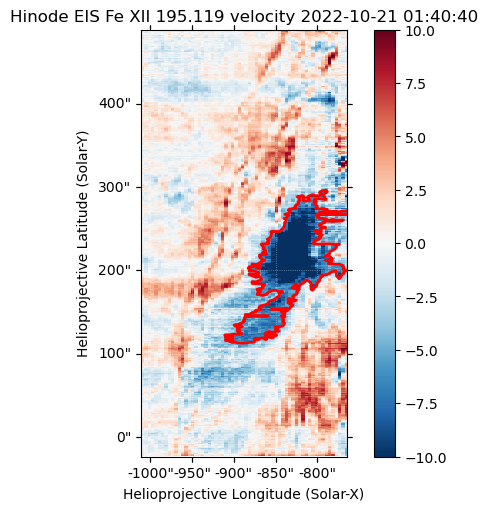

In [15]:
cs_selected_index_1021 = [1,2]
    
fig = plt.figure(figsize=(7, 5),layout='constrained')
ax = fig.add_subplot(111, projection=eis_FeXII_195_velmap_1021)
eis_FeXII_195_velmap_1021.plot(axes=ax)
plt.colorbar()

for ii in cs_selected_index_1021:
    ax.plot(*cs_1021.allsegs[0][ii].T, color='red', lw=2)

In [16]:
cs_skycoords_1021 = [eis_FeXII_195_velmap_1021.pixel_to_world(np.concatenate((cs_1021.allsegs[0][cs_selected_index_1021[0]][:,0],
                                                                    cs_1021.allsegs[0][cs_selected_index_1021[1]][:,0]))*u.pix,
                                                    np.concatenate((cs_1021.allsegs[0][cs_selected_index_1021[0]][:,1],
                                                                    cs_1021.allsegs[0][cs_selected_index_1021[1]][:,1]))*u.pix) \
                ]
cs_regions_1021 = [PolygonSkyRegion(vertices=cs_skycoord) for cs_skycoord in cs_skycoords_1021]

In [17]:
coronal_hole_ref_region_center_1021=SkyCoord(-760*u.arcsec, 280*u.arcsec, frame=eis_FeXII_195_intmap_1021.coordinate_frame)
eis_FeXII_195_intmap_coronal_hole_pixel_region_1021 = EllipsePixelRegion(center=PixCoord.from_sky(coronal_hole_ref_region_center_1021, 
                                                                                                  eis_FeXII_195_intmap_1021.wcs),
                                            width=(30*u.arcsec/eis_FeXII_195_intmap_1021.scale.axis1).to_value(u.pix), 
                                            height=(30*u.arcsec/eis_FeXII_195_intmap_1021.scale.axis2).to_value(u.pix))

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [18]:
coronal_hole_ref_region_params_1021 = {'center':coronal_hole_ref_region_center_1021, 'width':30*u.arcsec, 'height':30*u.arcsec}

In [19]:
def get_sky_region_centroid(sky_region, wcs):
    pixel_region = sky_region.to_pixel(wcs)
    pixel_region_shapely = shapely.geometry.Polygon(np.vstack(pixel_region.vertices.xy).T)
    pixel_region_shapely_centroid = pixel_region_shapely.centroid
    sky_coord_centroid = wcs.pixel_to_world(pixel_region_shapely_centroid.x, pixel_region_shapely_centroid.y)

    return sky_coord_centroid

In [20]:
def get_intensity_from_cs_regions(intensity_map, cs_regions):
    intensity = []
    masks = [np.where(cs_region.contains(sunpy.map.all_coordinates_from_map(intensity_map), 
                                                intensity_map.wcs)) for cs_region in cs_regions]
    intensity = [intensity_map.data[mask_] for mask_ in masks]
    return intensity

In [21]:
def mean_intensity_in_region(regions_intensity, min=None, max=None):
    if max is not None:
        for region_intensity in regions_intensity:
            mask = np.where(region_intensity > max)
            region_intensity[mask] = np.nan
    if min is not None:
        for region_intensity in regions_intensity:
            mask = np.where(region_intensity < min)
            region_intensity[mask] = np.nan
    return np.array([np.nanmean(region_intensity) for region_intensity in regions_intensity])

In [22]:
eis_radcal_file = readsav('../../sav/eis_radcal_20221025.sav',verbose=True)

--------------------------------------------------
Date: Thu Jun 27 11:54:26 2024
User: yjzhu
Host: NB-RES-YINGJIE
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.8.3
--------------------------------------------------
Successfully read 11 records of which:
 - 8 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - sw_wvl [<class 'numpy.ndarray'>]
 - lw_wvl [<class 'numpy.ndarray'>]
 - gdz_sw [<class 'numpy.ndarray'>]
 - gdz_lw [<class 'numpy.ndarray'>]
 - hpw_sw [<class 'numpy.ndarray'>]
 - hpw_lw [<class 'numpy.ndarray'>]
 - new_sw [<class 'numpy.ndarray'>]
 - new_lw [<class 'numpy.ndarray'>]
--------------------------------------------------


In [23]:
def get_eis_radcal(wvl,radcal_file=eis_radcal_file,method='hpw'):
    if isinstance(wvl, u.Quantity):
        wvl = wvl.to_value(u.angstrom)
        
    if method == 'hpw':
        lw_radcal = radcal_file['hpw_lw']
        sw_radcal = radcal_file['hpw_sw']
    elif method == 'lpw':
        lw_radcal = radcal_file['lpw_lw']
        sw_radcal = radcal_file['lpw_sw']
    elif method == 'new':
        lw_radcal = radcal_file['new_lw']
        sw_radcal = radcal_file['new_sw']
    
    if 165 < wvl < 212:
        radcal = sw_radcal
        wvl_grid = radcal_file['sw_wvl']
    elif 245 < wvl < 292:
        radcal = lw_radcal
        wvl_grid = radcal_file['lw_wvl']
    else:
        raise ValueError('Wavelength out of range')
    
    radcal_interp_func = scipy.interpolate.interp1d(wvl_grid, radcal, kind='cubic', fill_value='extrapolate')
    return radcal_interp_func(wvl)

In [24]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1),orientation="vertical"):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [37]:
def read_eis_fit_and_return_upflow_int(eis_file_prefix, eis_line_name,cs_regions,
                                       component=0, radcal_file=eis_radcal_file, method='hpw',
                                       int_hist=0, min=None, max=None, reference_region_params=None,
                                       short_range_stray_light=False, long_range_stray_light=False,
                                       long_range_stray_light_aia_ref=None, 
                                       long_range_stray_light_ref_center=None,
                                       long_range_stray_light_ref_radius=None,
                                       eis_aia_shift = (Txshift_aia_eis_rough_1025, Tyshift_aia_eis_rough_1025),
                                       eis_chi2_mask_threshold=50,
                                       short_range_stray_light_corr_ratio=1.,
                                       ax_eis=None,ax_hist=None,int_cmap='sdoaia193'):
    
    eis_fitres = eispac.read_fit(eis_file_prefix + eis_line_name + '.fit.h5')
    eis_intmap = eis_fitres.get_map(component=component, measurement='intensity')

    if eis_chi2_mask_threshold is not None and eis_chi2_mask_threshold > 0:
        chi2_mask = np.where(eis_fitres.fit['chi2'] > eis_chi2_mask_threshold)
        eis_intdata = eis_intmap.data.copy()
        eis_intdata[chi2_mask] = np.nan
        eis_intmap = sunpy.map.Map(eis_intdata, eis_intmap.meta)
    
    

    if eis_aia_shift is not None:
        eis_intmap = eis_intmap.shift_reference_coord(*eis_aia_shift)
    eis_intmap.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(eis_intmap.data, 0.5),
                                                      vmax=np.nanpercentile(eis_intmap.data, 99.5),
                                                      stretch=AsinhStretch(0.1))
    eis_intmap.plot_settings['cmap'] = int_cmap

    eis_regions_int = get_intensity_from_cs_regions(eis_intmap, cs_regions)
    eis_regions_int_mean = mean_intensity_in_region(eis_regions_int, min=min, max=max)
    eis_radcal_factor = get_eis_radcal(eis_intmap.wavelength, radcal_file=radcal_file, method=method)
    eis_regions_int_mean_radcal = eis_regions_int_mean*eis_radcal_factor
    
    # fig = plt.figure(figsize=(7, 5),layout='constrained')
    # ax = fig.add_subplot(111, projection=eis_intmap)
    eis_intmap.plot(axes=ax_eis, title=None)
    
    for ii, region in enumerate(cs_regions):
        ax_eis.plot_coord(region.vertices, color='#E83015', lw=1.3, label='Upflow Reg.' if ii == 0 else '')
    
    if reference_region_params is not None:
        referene_circle_pixel_region = EllipsePixelRegion(center=PixCoord.from_sky(reference_region_params['center'], eis_intmap.wcs),
                                            width=(reference_region_params['width']/eis_intmap.scale.axis1).to_value(u.pix), 
                                            height=(reference_region_params['height']/eis_intmap.scale.axis2).to_value(u.pix))
        referene_circle_pixel_region.plot(ax=ax_eis, edgecolor='#58B2DC', lw=1.3, label='CH Reg.')

    if short_range_stray_light or long_range_stray_light:
        stray_light_int = np.zeros((len(cs_regions),2))
        sr_stray_light_regions = []
        if short_range_stray_light is True:
            for ii, region in enumerate(cs_regions):
                sr_stray_light, sr_stray_light_region = calc_short_range_stray_light(eis_intmap,
                                                                                    get_sky_region_centroid(region, eis_intmap.wcs),
                                                                                    return_region=True)
                stray_light_int[ii,0] = sr_stray_light*short_range_stray_light_corr_ratio
                sr_stray_light_regions.append(sr_stray_light_region)

        if long_range_stray_light is True:
            lr_stray_light, lr_stray_light_coalign_region, lr_stray_light_aia_region = \
                            calc_long_range_stray_light_aia_eis(eis_intmap, long_range_stray_light_aia_ref,
                            SkyCoord(*long_range_stray_light_ref_center, frame=eis_intmap.coordinate_frame),
                            region_radius = long_range_stray_light_ref_radius,
                            return_region=True)
            
            lr_stray_light_coalign_region.plot(ax=ax_eis, edgecolor='#FAD689', lw=1.3, label='LRSL Reg.')
            stray_light_int[:,1] = lr_stray_light

            # aia_map_crop = long_range_stray_light_aia_ref.submap(eis_intmap.bottom_left_coord, top_right=eis_intmap.top_right_coord)
            # fig_aia = plt.figure(figsize=(7, 5),layout='constrained')
            # ax_aia = fig_aia.add_subplot(111, projection=aia_map_crop)
            # aia_map_crop.plot(axes=ax_aia)
            # lr_stray_light_aia_region.to_sky(long_range_stray_light_aia_ref.wcs).to_pixel(aia_map_crop.wcs).plot(ax=ax_aia, edgecolor='#FAD689', lw=1.3, label='LRSL AIA Ref. Region')
            
    if int_hist is not False:
        if isinstance(int_hist, int) and (0 <= int_hist < len(cs_regions)):
        #     fig_hist, ax_hist = plt.subplots(layout='constrained')
            ax_hist.hist(eis_regions_int[int_hist], bins=10, histtype='bar', color='#E83015', lw=1.3, alpha=0.3,
                    range=(np.nanmin(eis_regions_int[int_hist]),np.nanmax(eis_regions_int[int_hist])),
                    label='Upflow Reg.', weights=np.ones_like(eis_regions_int[int_hist])/len(eis_regions_int[int_hist]),
                    orientation='horizontal')
            
            eis_regions_int_kde = gaussian_kde(eis_regions_int[int_hist])
            x = np.linspace(np.nanmin(eis_regions_int[int_hist]), np.nanmax(eis_regions_int[int_hist]), 50)
            ax_hist.plot(eis_regions_int_kde(x)*np.diff(x)[0]*5, x, color='#E83015', lw=1.3, ls='--')
            
            if min is not None:
                ax_hist.axvline(min, color='#E83015', lw=1.3, ls='--')
            if max is not None:
                ax_hist.axvline(max, color='#E83015', lw=1.3, ls='--')
        
        if reference_region_params is not None:
            reference_region_mask = np.where(referene_circle_pixel_region.contains(PixCoord.from_sky(sunpy.map.all_coordinates_from_map(eis_intmap),
                                                                                                     eis_intmap.wcs)))
            ax_hist.hist(eis_intmap.data[reference_region_mask], bins=10, histtype='bar', color='#58B2DC', lw=1.3, alpha=0.3,
                    range=(np.nanmin(eis_intmap.data[reference_region_mask]),np.nanmax(eis_intmap.data[reference_region_mask])),
                    label='CH Reg.', weights=np.ones_like(eis_intmap.data[reference_region_mask])/len(eis_intmap.data[reference_region_mask]),
                    orientation='horizontal')
            
            eis_reference_region_int_kde = gaussian_kde(eis_intmap.data[reference_region_mask])
            x = np.linspace(np.nanmin(eis_intmap.data[reference_region_mask]), np.nanmax(eis_intmap.data[reference_region_mask]), 50)
            ax_hist.plot(eis_reference_region_int_kde(x)*np.diff(x)[0]*5, x, color='#58B2DC', lw=1.3, ls='--')
            
        if short_range_stray_light is True:
            ax_hist.axhline(stray_light_int[int_hist,0], color='#90B44B', lw=1.3, ls='--', label='SRSL',alpha=0.8)
            sr_stray_light_regions[int_hist].plot(ax=ax_eis, edgecolor='#90B44B', lw=1.3, label='SRSL Reg.')

        if long_range_stray_light is True:
            ax_hist.axhline(stray_light_int[int_hist,1], color='#FAD689', lw=1.3, ls='--', label='LRSL',alpha=0.8)

        if short_range_stray_light is True and long_range_stray_light is True:
            ax_hist.axhline(np.sum(stray_light_int[int_hist,:]), color='#B28FCE', lw=1.3, ls='--', label='Total SL',alpha=0.8)
        
        # ax_hist.legend(loc='upper right')
        ax_hist.set_ylim(bottom=0)
        ax_hist.set_ylabel(r'Intensity [erg cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
        ax_hist.set_yscale('function',functions=(np.sqrt, np.square))
        ax_hist.yaxis.set_minor_locator(AutoMinorLocator(5))

    
        # ax_leg = ax_eis.legend(bbox_to_anchor=(1.4, 0.7, 0.5, 0.3))
        # leg_box = ax_leg.get_window_extent(renderer=fig.canvas.get_renderer())
        # leg_box_ax_coords = leg_box.transformed(ax.transAxes.inverted())

        # plot_colorbar(ax_eis.images[0],ax_eis,width='5%',bbox_to_anchor=(1.07, 0., 1, leg_box_ax_coords.y0 - 0.05),fontsize=12)

    # if short_range_stray_light is True or long_range_stray_light is True:
    #     return eis_regions_int_mean_radcal, stray_light_int*eis_radcal_factor
    # else:
    #     return eis_regions_int_mean_radcal

<a id='figure-c-1'></a>
### Figure C.1
(You may have to pull down to see the notebook preview of the figure)

[back to top](#notebook-top) 

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_14_270_519.2c-1.fit.h5
INFO: uncertainty should have attribute uncertainty_ty

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/matplotlib/scale.py:153: RuntimeWarning: invalid value encountered in sqrt
  return self._forward(values)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/matplotlib/scale.py:153: RuntimeWarning: invalid value encountered in sqrt
  return self._forward(values)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/matplotlib/scale.py:153: RuntimeWarning: invalid value encountered in sqrt
  return self._forward(values)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/matplotlib/scale.py:153: RuntimeWarning: invalid value encountered in sqrt
  return self._forward(values)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/matplotlib/scale.py:153: RuntimeWarning: invalid value encountered in sqrt
  return self._forward(values)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/matplotlib/scale.py:153: RuntimeWarning: invalid value encountered in sqrt
  return self._forward(

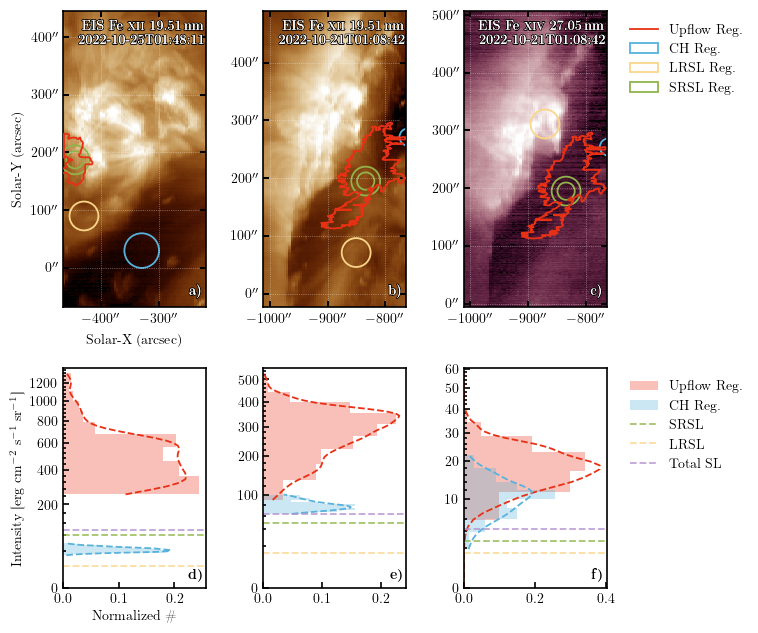

In [38]:
with rc_context(ms_style_dict):
    fig = plt.figure(figsize=(7.5,6.3),layout='constrained')
    gs = fig.add_gridspec(2, 3, height_ratios=[3,2])

    ax1 = fig.add_subplot(gs[0,0], projection=eis_FeXII_195_intmap_1025)
    ax2 = fig.add_subplot(gs[0,1], projection=eis_FeXII_195_intmap_1021)
    ax3 = fig.add_subplot(gs[0,2], projection=eis_FeXIV_270_intmap_1021)
    ax4 = fig.add_subplot(gs[1,0])
    ax5 = fig.add_subplot(gs[1,1])
    ax6 = fig.add_subplot(gs[1,2])

    read_eis_fit_and_return_upflow_int(eis_file_prefix_1025, 'fe_12_195_119.1c-0', cs_regions_1025,
                                                                                        reference_region_params=coronal_hole_ref_region_params_1025,
                                                                                        short_range_stray_light=True,
                                                                                        long_range_stray_light=True,
                                                                                        long_range_stray_light_aia_ref=aia_193_map_1025,
                                                                                        long_range_stray_light_ref_center=[-430,90]*u.arcsec,
                                                                                        long_range_stray_light_ref_radius=50*u.arcsec,
                                                                                        ax_eis=ax1,ax_hist=ax4)

    read_eis_fit_and_return_upflow_int(eis_file_prefix_1021, 'fe_12_195_119.1c-0', cs_regions_1021,
                                                                                        reference_region_params=coronal_hole_ref_region_params_1021,
                                                                                        short_range_stray_light=True,
                                                                                        long_range_stray_light=True,
                                                                                        long_range_stray_light_aia_ref=aia_193_map_1021,
                                                                                        long_range_stray_light_ref_center=[-850,80]*u.arcsec,
                                                                                        long_range_stray_light_ref_radius=50*u.arcsec,
                                                                                        ax_eis=ax2,ax_hist=ax5)

    read_eis_fit_and_return_upflow_int(eis_file_prefix_1021, 'fe_14_270_519.2c-1', cs_regions_1021,
                                                                                      component=1,int_hist=0,
                                                                                      reference_region_params=coronal_hole_ref_region_params_1021,         
                                                                                        short_range_stray_light=True,
                                                                                      long_range_stray_light=True,
                                                                                      long_range_stray_light_aia_ref=aia_211_map_1021,
                                                                                      long_range_stray_light_ref_center=[-870,320]*u.arcsec,
                                                                                      long_range_stray_light_ref_radius=50*u.arcsec,
                                                                                      ax_eis=ax3,ax_hist=ax6, int_cmap='sdoaia211')                                                                                    
    ax1.set_xlabel('Solar-X (arcsec)')
    ax1.set_ylabel('Solar-Y (arcsec)')
    ax4.set_xlabel(r'Normalized \#')
    ax2.coords[0].axislabels.set_visible(False)
    ax3.coords[0].axislabels.set_visible(False)
    ax2.coords[1].axislabels.set_visible(False)
    ax3.coords[1].axislabels.set_visible(False)

    ax5.yaxis.get_label().set_visible(False)
    ax6.yaxis.get_label().set_visible(False)

    ax3.legend(bbox_to_anchor=(1.08, 0.7, 0.5, 0.3), frameon=False)
    ax6.legend(bbox_to_anchor=(1.08, 0.7, 0.5, 0.3), frameon=False)


    ax1.text(1.1,0.97,r'\textbf{EIS Fe \textsc{xii} 19.51\,nm}' + \
                      '\n' + r'\textbf{{{}}}'.format(eis_FeXII_195_intmap_1025.meta['date_obs'][:-4]),
             transform=ax1.transAxes, 
             ha='right', va='top', color='white',
             path_effects=[path_effects.withStroke(linewidth=1.2, foreground='black'),
                           path_effects.Normal()])
    
    ax2.text(1.1,0.97,r'\textbf{EIS Fe \textsc{xii} 19.51\,nm}' + \
                      '\n' + r'\textbf{{{}}}'.format(eis_FeXII_195_intmap_1021.meta['date_obs'][:-4]),
              transform=ax2.transAxes,
              ha='right', va='top', color='white',
              path_effects=[path_effects.withStroke(linewidth=1.2, foreground='black'),
                            path_effects.Normal()])
    
    ax3.text(1.1,0.97,r'\textbf{EIS Fe \textsc{xiv} 27.05\,nm}' + \
                      '\n' + r'\textbf{{{}}}'.format(eis_FeXIV_270_intmap_1021.meta['date_obs'][:-4]),
              transform=ax3.transAxes,
              ha='right', va='top', color='white',
              path_effects=[path_effects.withStroke(linewidth=1.2, foreground='black'),
                            path_effects.Normal()])

    ax1.text(0.98,0.03,r'\textbf{a)}',
            transform=ax1.transAxes,
            ha='right', va='bottom', color='white',
            path_effects=[path_effects.withStroke(linewidth=1.2, foreground='black'),
                          path_effects.Normal()])
    ax2.text(0.98,0.03,r'\textbf{b)}',
            transform=ax2.transAxes,
            ha='right', va='bottom', color='white',
            path_effects=[path_effects.withStroke(linewidth=1.2, foreground='black'),
                          path_effects.Normal()])
    ax3.text(0.98,0.03,r'\textbf{c)}',
            transform=ax3.transAxes,
            ha='right', va='bottom', color='white',
            path_effects=[path_effects.withStroke(linewidth=1.2, foreground='black'),
                          path_effects.Normal()]) 
    
    ax4.text(0.98,0.03,r'\textbf{d)}',
            transform=ax4.transAxes,
            ha='right', va='bottom', color='black',)

    ax5.text(0.98,0.03,r'\textbf{e)}',
            transform=ax5.transAxes,
            ha='right', va='bottom', color='black',)
    
    ax6.text(0.98,0.03,r'\textbf{f)}',
            transform=ax6.transAxes,
            ha='right', va='bottom', color='black',)

    for ax_ in (ax1,ax2,ax3):
        ax_.coords[0].set_ticks(number=3)

    fig.get_layout_engine().set(w_pad=4/72, h_pad=0, hspace=0,
                            wspace=0)

    plt.savefig("../../figs/ms_eis_eui_upflow/eis_stray_light.pdf",dpi=300,bbox_inches="tight")

    plt.show()